# An image is worth 16$\times$16 words: Transformers for image recognition at scale

https://arxiv.org/abs/2010.11929

"A pure transformer applied directly to sequence of image patches can perform very well on image classification tasks."

![](https://github.com/yongbinkim-chemist/deep_learning/blob/main/computer_vision/images/ViT_architecture_overview.png?raw=true)

In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Split an image into fixed-size patches

Reshape original 2D image $H \times W \times C$ into a sequence of flattened 2D patches $N \times P^2 \cdot C$:

where
- $H$, $W$, $C$: height, width, and color channels
- $P^2 = P \times P$: patch resolution
- $N = HW / P^2$: number of patches

**Note** $HW$ should be divisible by $P^2$

### 1.1 Download image data

In [20]:
from pathlib import Path
import shutil
import os
import requests
import zipfile

data_path = Path("data")
image_path = data_path / "food-101-mini"
if image_path.exists():
  print(f"{data_path} exists, skipping download..")
else:
  image_path.mkdir(parents=True, exist_ok=True)
  with open(image_path / "food-101-mini.zip", "wb") as f:
    print("Downloading data..")
    r = requests.get("https://github.com/yongbinkim-chemist/deep_learning/raw/refs/heads/main/computer_vision/data/food-101-mini/food-101-mini.zip")
    f.write(r.content)
  with zipfile.ZipFile(image_path / "food-101-mini.zip", "r") as zip_ref:
    print("Extracting data..")
    zip_ref.extractall(image_path)
  os.remove(image_path / "food-101-mini.zip")
  shutil.rmtree(image_path / "__MACOSX")

Extracting data..


In [22]:
def set_seeds(seed: int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

### 1.2 Create dataloaders

1. create transforms
2. split train and test dataset
3. convert them into PyTorch Dataloaders

In [25]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [32]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Table 3 -> training resolution is 224
    transforms.ToTensor()
    ])

image_datasets = datasets.ImageFolder(image_path,
                                      transform=data_transform)

class_names = image_datasets.classes

samples = [label for _, label in image_datasets.samples]
train_idx, test_idx = train_test_split(
    list(range(len(samples))),
    test_size=0.2,
    stratify=samples,
    random_state=42 # reproducibility purpose
)

train_dataset = Subset(image_datasets, train_idx)
test_dataset = Subset(image_datasets, test_idx)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32, # hyperparameter, we have way less number of images; paper batch size=4096, JFT-300M (ViT-B, Table3)
                              shuffle=True,
                              num_workers=os.cpu_count(),
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=os.cpu_count(),
                             pin_memory=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79c446a9c1a0>,
 <torch.utils.data.dataloader.DataLoader at 0x79c42430a960>)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


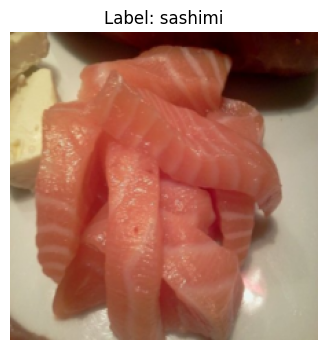

In [43]:
img_batch, label_batch = next(iter(train_dataloader))

img, label = img_batch[0], label_batch[0]

plt.figure(figsize=(6, 4))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_names[label]}")
plt.axis(False);

### 1.3 Patchfy images

patch resolution = 16 $\times$ 16

In [45]:
height = 224
width = 224
color_channels = 3
patch_size = 16

assert (height * width) % (patch_size**2) == 0, "Image resolution must be divisible by patch size"

patch_num = (height * width) // (patch_size ** 2)
patch_num

196

In [47]:
permuted_image = img.permute(1, 2, 0)
permuted_image.shape

torch.Size([224, 224, 3])

In [52]:
224/16

14.0

<Figure size 1000x600 with 0 Axes>

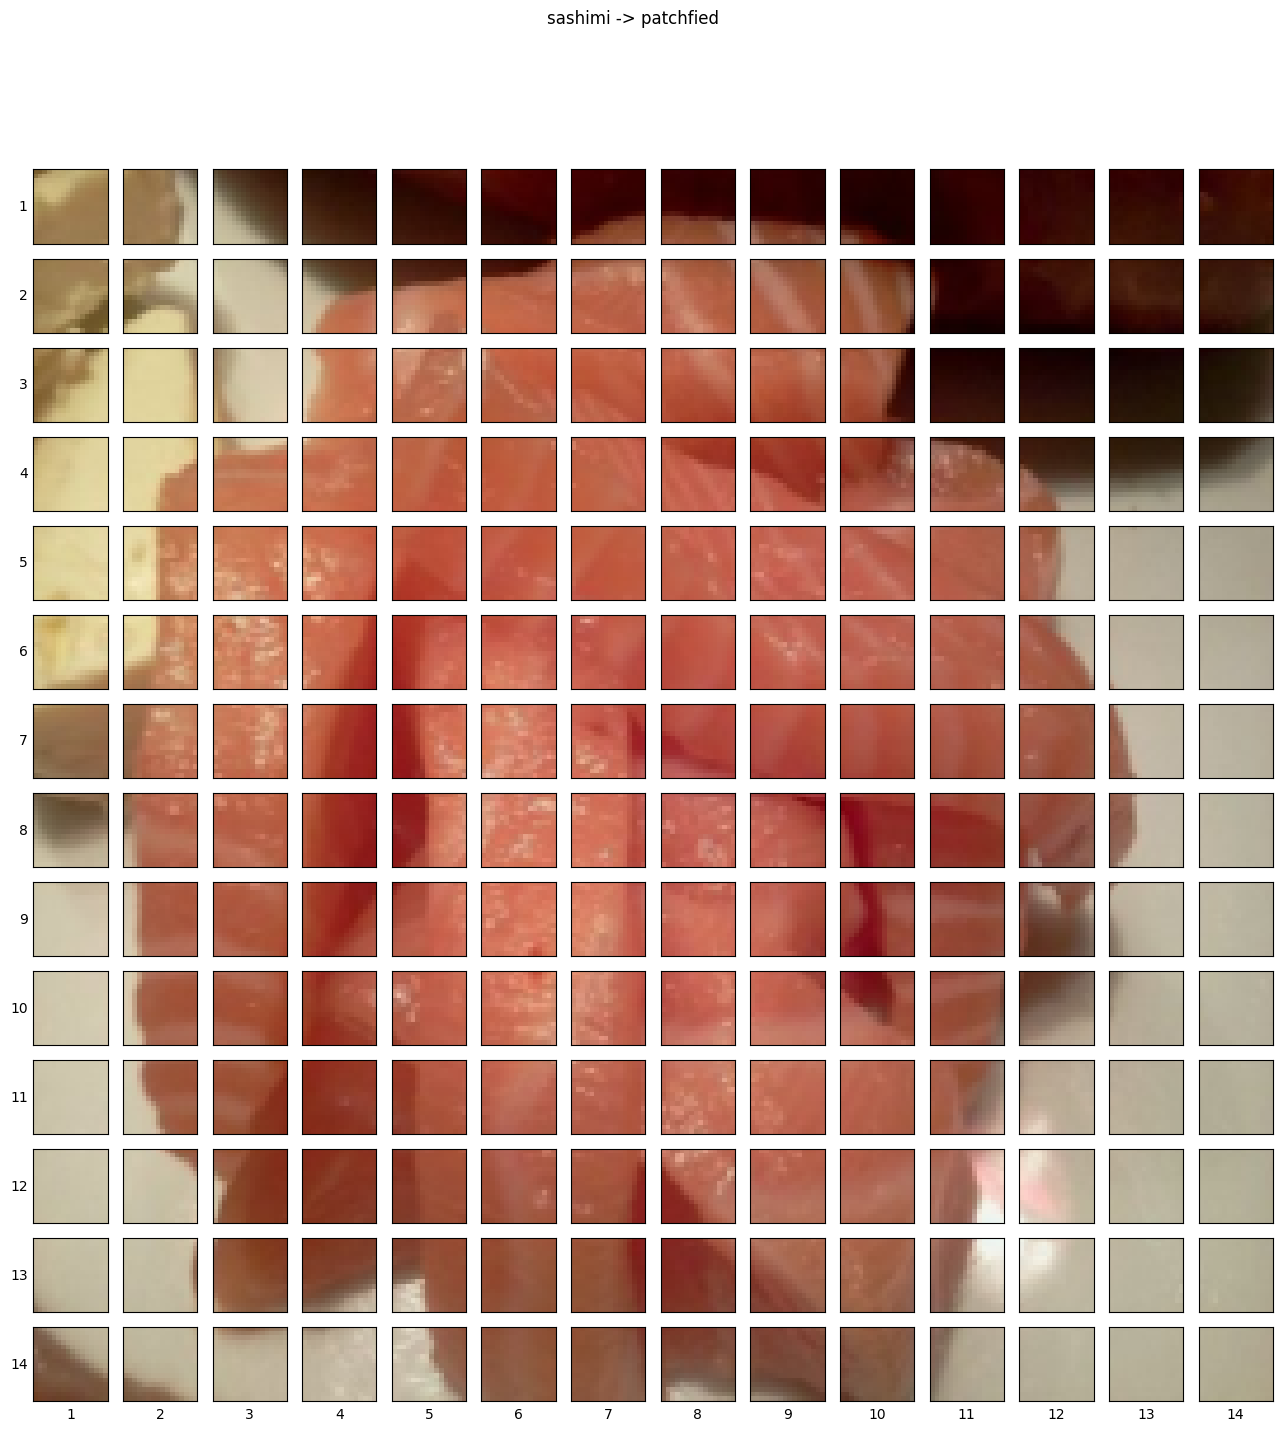

In [59]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(nrows=width // patch_size,
                         ncols=height // patch_size,
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))

for i, patch_i in enumerate(range(0, height, patch_size)):
  for j, patch_j in enumerate(range(0, width, patch_size)):
    axes[i,j].imshow(permuted_image[patch_i:patch_i+patch_size, patch_j:patch_j+patch_size, :])
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    axes[i,j].set_xlabel(j+1)
    axes[i,j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axes[i,j].label_outer()

fig.suptitle(f"{class_names[label]} -> patchfied")
plt.show();